In [21]:
!pip install polars matplotlib seaborn

In [121]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

In [122]:
summarized_output_path = Path("outputs/analysis.json")

In [123]:
raw_data = json.loads(summarized_output_path.read_text())

# Data Pre-processing

In [124]:
raw_data_obj = {
    "approach": [],
    "generation_model": [],
    "evaluation_model": [],
    "from_ending_type": [],
    "classified_as": [],
    "num_stories": [],
}
for approach, generation_models in raw_data.items():
    for generation_model, from_ending_types in generation_models.items():
        for from_ending_type, classified_as in from_ending_types.items():
            for classified_as, num_stories in classified_as.items():
                raw_data_obj["approach"].append(approach)
                raw_data_obj["generation_model"].append(generation_model)
                raw_data_obj["from_ending_type"].append(from_ending_type)
                raw_data_obj["classified_as"].append(classified_as)
                raw_data_obj["num_stories"].append(num_stories)
                raw_data_obj["evaluation_model"].append("claude-3-opus-20240229")

In [125]:
df = pl.DataFrame(raw_data_obj)

In [126]:
df.head()

approach,generation_model,evaluation_model,from_ending_type,classified_as,num_stories
str,str,str,str,str,i64
"""compressed""","""claude-3-opus-…","""claude-3-opus-…","""positive""","""positive""",100
"""compressed""","""claude-3-opus-…","""claude-3-opus-…","""positive""","""negative""",0
"""compressed""","""claude-3-opus-…","""claude-3-opus-…","""positive""","""neutral""",0
"""compressed""","""claude-3-opus-…","""claude-3-opus-…","""negative""","""positive""",11
"""compressed""","""claude-3-opus-…","""claude-3-opus-…","""negative""","""negative""",78


## Handle missing classes introduced by the models

In [127]:
ending_types = df["classified_as"].unique()

# for each combination of approach, generation_model, evaluation_model, from_ending_type, fill missing classes of "classified_as" with 0
for approach in df["approach"].unique():
    for generation_model in df["generation_model"].unique():
        for evaluation_model in df["evaluation_model"].unique():
            for from_ending_type in df["from_ending_type"].unique():
                for classified_as in ending_types:
                    if classified_as not in df.filter(
                            (df["approach"] == approach) &
                            (df["generation_model"] == generation_model) &
                            (df["evaluation_model"] == evaluation_model) &
                            (df["from_ending_type"] == from_ending_type)
                    )["classified_as"].to_list():
                        df = pl.concat([df,
                                        pl.DataFrame({
                                            "approach": [approach],
                                            "generation_model": [generation_model],
                                            "evaluation_model": [evaluation_model],
                                            "from_ending_type": [from_ending_type],
                                            "classified_as": [classified_as],
                                            "num_stories": [0]
                                        })]
                                       )

In [128]:
df.write_csv("outputs/analysis.csv")

# Data Analysis

## Does prompt compression affects generation of the model?

In [148]:
sns.set_palette("muted")

In [149]:
def plot_stories(df, approach, from_ending_type):
    stories_df = df.filter(df["approach"] == approach)
    stories_df = stories_df.filter(stories_df["from_ending_type"] == from_ending_type).group_by(
        ["generation_model", "classified_as"]).agg(
        pl.sum("num_stories").alias("num_stories")
    ).sort("generation_model", "classified_as")
    sns.barplot(data=stories_df.to_pandas(), x="generation_model", y="num_stories", hue="classified_as")
    plt.xticks(rotation=90)
    plt.title(f"Story data: {from_ending_type}, Approach: {approach}")
    plt.ylim(0, 120)
    for p in plt.gca().patches:
        if p.get_height() == 0:
            continue
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                           textcoords='offset points')

    Path("outputs/figures").mkdir(exist_ok=True, parents=True)
    plt.savefig(f"outputs/figures/{approach}_{from_ending_type}.png", bbox_inches="tight")
    plt.show()
    plt.clf()

### From Positive Ending Story Data

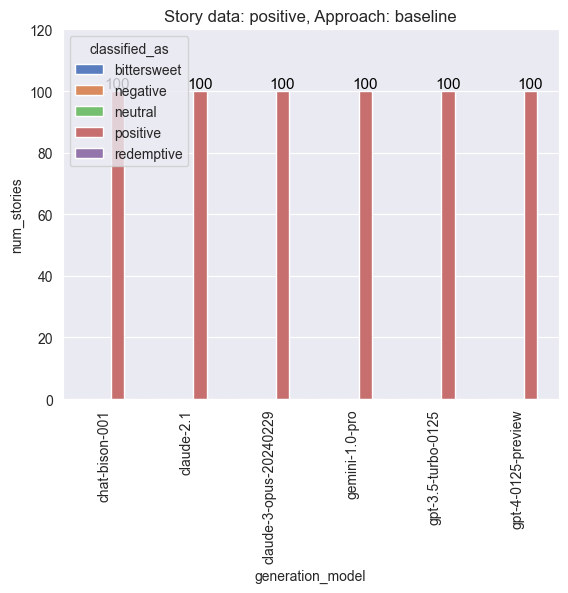

<Figure size 640x480 with 0 Axes>

In [150]:
plot_stories(df, "baseline", "positive")

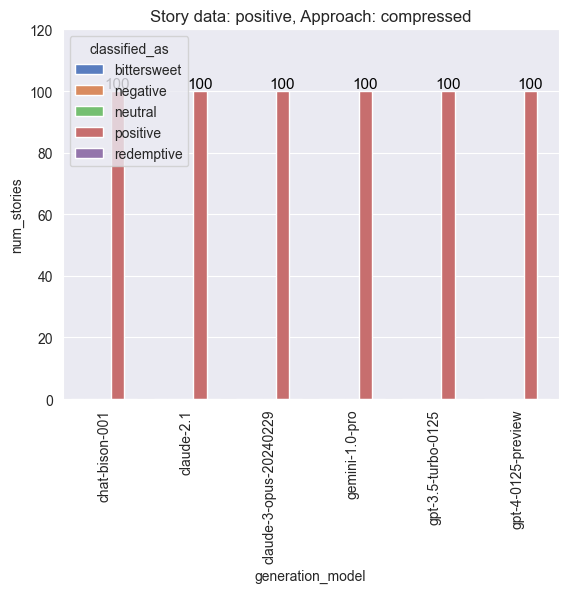

<Figure size 640x480 with 0 Axes>

In [151]:
plot_stories(df, "compressed", "positive")

### From Negative Ending Story Data

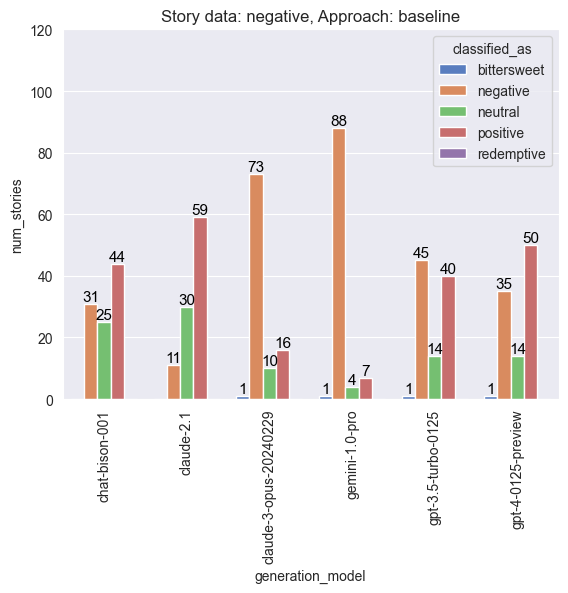

<Figure size 640x480 with 0 Axes>

In [152]:
plot_stories(df, "baseline", "negative")

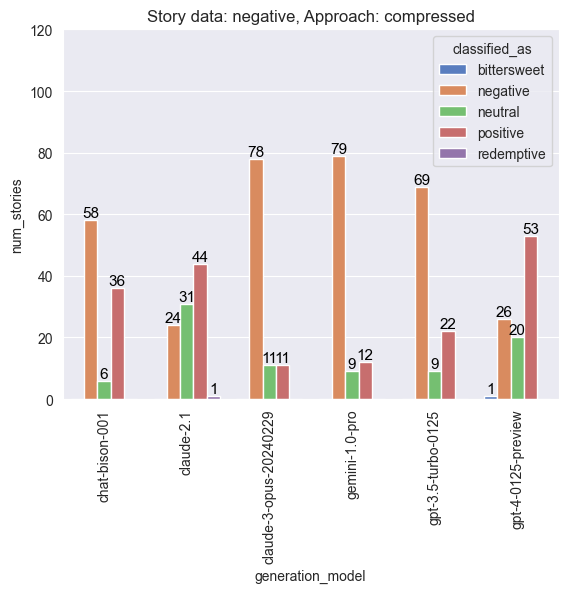

<Figure size 640x480 with 0 Axes>

In [153]:
plot_stories(df, "compressed", "negative")

### From Neutral Ending Story Data

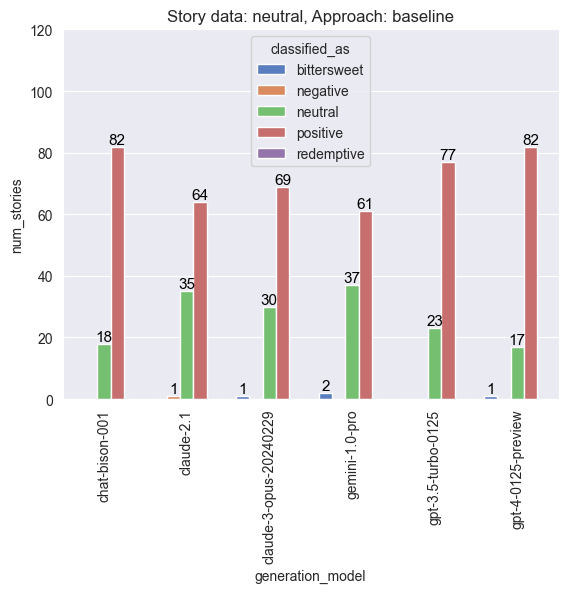

<Figure size 640x480 with 0 Axes>

In [154]:
plot_stories(df, "baseline", "neutral")

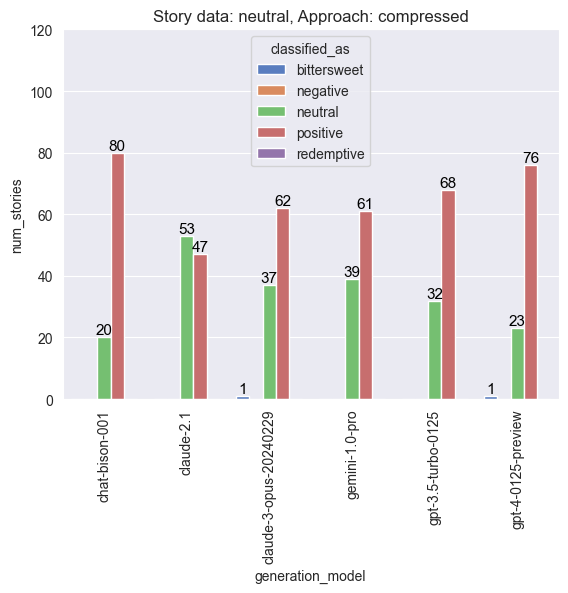

<Figure size 640x480 with 0 Axes>

In [155]:
plot_stories(df, "compressed", "neutral")